In [13]:
import os
import re
import json
import warnings
from typing import List, Tuple, Optional

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


try:
    import regex as re2
except Exception:
    re2 = re


try:
    from ftfy import fix_text
except Exception:
    def fix_text(x): return x

try:
    from unidecode import unidecode
except Exception:
    def unidecode(x): return x


PRESIDIO_AVAILABLE = False
try:
    from presidio_analyzer import AnalyzerEngine
    from presidio_anonymizer import AnonymizerEngine
    PRESIDIO_AVAILABLE = True
except Exception:
    PRESIDIO_AVAILABLE = False


CSV_PATH = "mental_health_counseling_conversations_rated.csv"  
OUTPUT_DIR = "data/processed"
SEED = 42
REMOVE_EMOJI = True
LOWERCASE = True
USE_PRESIDIO = False  

os.makedirs(OUTPUT_DIR, exist_ok=True)
np.random.seed(SEED)


In [14]:
df = pd.read_csv(CSV_PATH)
print(df.shape)
df.head()
df.columns.tolist()

(3512, 26)


['index',
 'context',
 'response',
 'empathy_llama-3-2-1b',
 'empathy_llama-3-2-3b',
 'empathy_llama-3-1-8b',
 'empathy_qwen-2-5-7b',
 'appropriateness_llama-3-2-1b',
 'appropriateness_llama-3-2-3b',
 'appropriateness_llama-3-1-8b',
 'appropriateness_qwen-2-5-7b',
 'relevance_llama-3-2-1b',
 'relevance_llama-3-2-3b',
 'relevance_llama-3-1-8b',
 'relevance_qwen-2-5-7b',
 'explanation_llama-3-2-1b',
 'explanation_llama-3-2-3b',
 'explanation_llama-3-1-8b',
 'explanation_qwen-2-5-7b',
 'generated_text_llama-3-2-1b',
 'generated_text_llama-3-2-3b',
 'generated_text_llama-3-1-8b',
 'generated_text_qwen-2-5-7b',
 'avg_empathy_score',
 'avg_appropriateness_score',
 'avg_relevance_score']

In [15]:
id_col = "index"


BASE_TEXT_COLS = ["context", "response"]


RATING_COLS = ["avg_empathy_score", "avg_appropriateness_score", "avg_relevance_score"]

MODEL_SCORE_COLS = [
    'empathy_llama-3-2-1b','empathy_llama-3-2-3b','empathy_llama-3-1-8b','empathy_qwen-2-5-7b',
    'appropriateness_llama-3-2-1b','appropriateness_llama-3-2-3b','appropriateness_llama-3-1-8b','appropriateness_qwen-2-5-7b',
    'relevance_llama-3-2-1b','relevance_llama-3-2-3b','relevance_llama-3-1-8b','relevance_qwen-2-5-7b'
]
EXPLANATION_COLS = [c for c in df.columns if c.startswith("explanation_")]
GENERATED_COLS = [c for c in df.columns if c.startswith("generated_text_")]

MODEL_SCORE_COLS = [c for c in MODEL_SCORE_COLS if c in df.columns]
EXPLANATION_COLS = [c for c in EXPLANATION_COLS if c in df.columns]
GENERATED_COLS = [c for c in GENERATED_COLS if c in df.columns]


for rc in RATING_COLS + MODEL_SCORE_COLS:
    if rc in df.columns:
        df[rc] = pd.to_numeric(df[rc], errors="coerce")

In [16]:
def build_text_from_context_response(row):
    parts = []
    for c in BASE_TEXT_COLS:
        if c in row and isinstance(row[c], str) and row[c].strip():
            parts.append(row[c].strip())
    return " [CTX] ".join(parts) if parts else ""

df["text"] = df.apply(build_text_from_context_response, axis=1)


df["text"] = df["text"].map(lambda x: basic_sanitize(x, remove_emoji=REMOVE_EMOJI, lowercase=LOWERCASE))


df["text_len"] = df["text"].astype(str).str.split().apply(len)
before = len(df)
df = df[df["text"].str.strip() != ""]
df = df[df["text_len"] >= 2]
df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)
print(f"Filtered {before - len(df)} rows; remain = {len(df)}")
df[["text","text_len"] + RATING_COLS].head(3)

Filtered 1483 rows; remain = 2029


,text,text_len,avg_empathy_score,avg_appropriateness_score,avg_relevance_score
0,i'm going through some things with my feelings...,224,2.5,2.75,4.25
1,i'm going through some things with my feelings...,429,4.5,5.00,4.75
2,i'm going through some things with my feelings...,121,3.0,4.25,3.25


In [17]:
keep_cols = [id_col] if id_col in df.columns else []
keep_cols += ["text", "text_len"]
keep_cols += [c for c in RATING_COLS if c in df.columns]


keep_cols = list(dict.fromkeys([c for c in keep_cols if c in df.columns]))
cleaned = df[keep_cols].copy()
cleaned.head()

,index,text,text_len,avg_empathy_score,avg_appropriateness_score,avg_relevance_score
0,0,i'm going through some things with my feelings...,224,2.50,2.75,4.25
1,1,i'm going through some things with my feelings...,429,4.50,5.00,4.75
2,2,i'm going through some things with my feelings...,121,3.00,4.25,3.25
3,3,i'm going through some things with my feelings...,198,3.00,4.50,4.75
4,4,i'm going through some things with my feelings...,124,3.25,4.50,3.75


In [18]:
BIN_TARGET = "avg_empathy_score"
BIN_COL = None
if BIN_TARGET in cleaned.columns:

    cleaned["emp_bin"] = pd.qcut(cleaned[BIN_TARGET].astype(float), q=3, labels=[0,1,2], duplicates="drop")
    BIN_COL = "emp_bin"

cleaned[BIN_COL].value_counts(dropna=False) if BIN_COL else "No binning"


emp_bin
0    850
2    672
1    507
Name: count, dtype: int64

In [19]:
from sklearn.model_selection import train_test_split
SEED = 42

if BIN_COL:
    train, tv = train_test_split(cleaned, test_size=0.2, random_state=SEED,
                                 stratify=cleaned[BIN_COL])
    val, test = train_test_split(tv, test_size=0.5, random_state=SEED,
                                 stratify=tv[BIN_COL])
else:
    train, tv = train_test_split(cleaned, test_size=0.2, random_state=SEED)
    val, test = train_test_split(tv, test_size=0.5, random_state=SEED)

print("sizes:", len(train), len(val), len(test))

os.makedirs(OUTPUT_DIR, exist_ok=True)
train.to_csv(os.path.join(OUTPUT_DIR, "train.csv"), index=False)
val.to_csv(os.path.join(OUTPUT_DIR, "val.csv"), index=False)
test.to_csv(os.path.join(OUTPUT_DIR, "test.csv"), index=False)


def summarize_metadata(df: pd.DataFrame, text_col: str, rating_cols: list) -> pd.DataFrame:
    summary = {
        "num_rows": [len(df)],
        "num_unique_text": [df[text_col].nunique()],
        "avg_len_chars": [df[text_col].str.len().mean()],
        "avg_len_words": [df[text_col].str.split().apply(len).mean()],
        "num_missing_text": [df[text_col].isna().sum()],
    }
    for rc in rating_cols:
        if rc in df.columns:
            summary[f"missing_{rc}"] = df[rc].isna().sum()
            if pd.api.types.is_numeric_dtype(df[rc]):
                summary[f"{rc}_mean"] = df[rc].astype(float).mean()
    return pd.DataFrame(summary)

meta = summarize_metadata(cleaned, "text", RATING_COLS)
os.makedirs("data", exist_ok=True)
meta.to_csv("data/metadata_summary.csv", index=False)

train.head(2), val.head(2), test.head(2)


sizes: 1623 203 203


(     index                                               text  text_len  \
 30      30  i have so many issues to address. i have a his...       139   
 553    553  my toddler defies everything i say and doesn't...       177   
 
      avg_empathy_score  avg_appropriateness_score  avg_relevance_score emp_bin  
 30                3.75                       4.00                 5.00       1  
 553               3.25                       4.75                 3.75       0  ,
       index                                               text  text_len  \
 1113   1113  my fiance and i have been together for 3 years...       401   
 552     552  my toddler defies everything i say and doesn't...       484   
 
       avg_empathy_score  avg_appropriateness_score  avg_relevance_score  \
 1113                4.0                        4.5                 4.75   
 552                 4.0                        5.0                 4.75   
 
      emp_bin  
 1113       2  
 552        2  ,
       inde

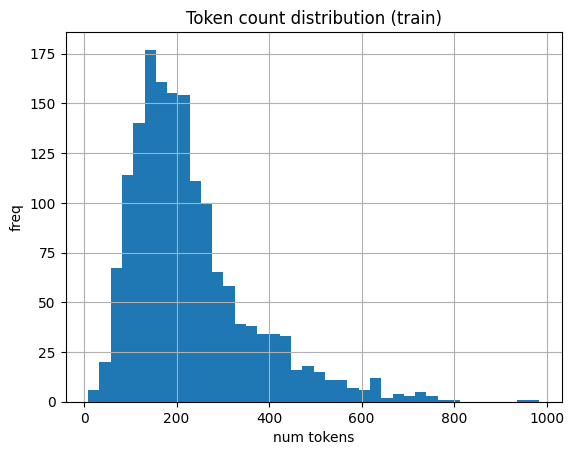

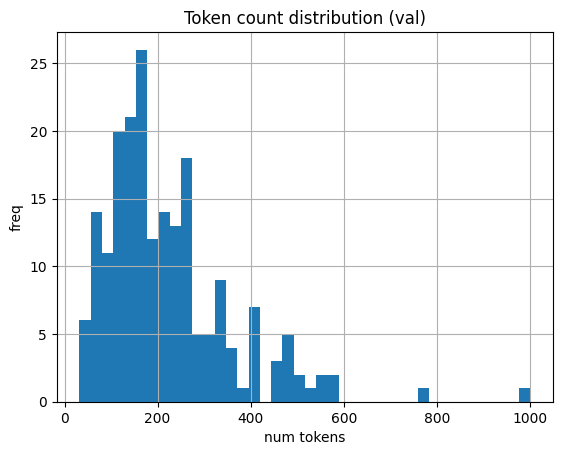

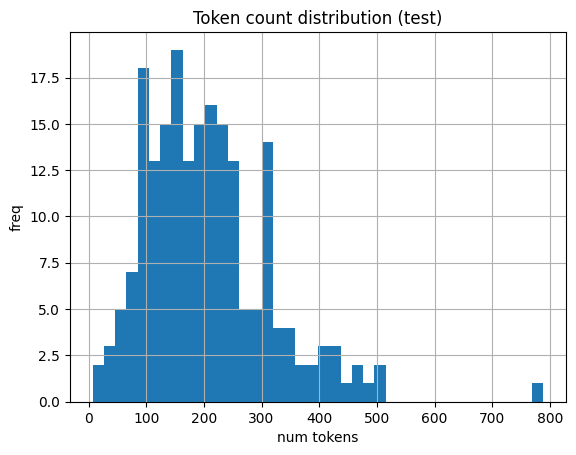

In [20]:
import matplotlib.pyplot as plt

for split_name, split_df in [("train", train), ("val", val), ("test", test)]:
    if "text_len" not in split_df.columns:
        split_df["text_len"] = split_df["text"].astype(str).str.split().apply(len)
    ax = split_df["text_len"].hist(bins=40)
    plt.title(f"Token count distribution ({split_name})")
    plt.xlabel("num tokens"); plt.ylabel("freq")
    plt.show()
